# EDA + CenterNet Baseline

References:
* Took 3D visualization code from https://www.kaggle.com/zstusnoopy/visualize-the-location-and-3d-bounding-box-of-car
* CenterNet paper https://arxiv.org/pdf/1904.07850.pdf
* CenterNet repository https://github.com/xingyizhou/CenterNet

Change log:
* v14: better inference: added `optimize_xy` function | LB 0.093
* v15: horizontal flip augmentation | ERROR
* v16: faster training (made smaller padding) | LB 0.089
* v17: smaller image size and better image proportions | LB 0.066
* v18: image size back; changed flip probability; **new visualizations** | LB ?

# What is this competition about?
1. You are given the images taken from the roof of a car
    * ~4k training images
    * Always the same car and the same camera
2. You are asked to detect other cars on that image
    * There can be many cars
    * You need to predict their positions
![](https://i.ibb.co/7RJ2Wbs/results-33-2.png)

## What is in this notebook?
* Data distributions: 1D, 2D and 3D
* Functions to transform between camera coordinates and road coordinates
* Simple CenterNet baseline

## CenterNet
This architecture predicts centers of objects as a heatmap.  
It predicts sizes of the boxes as a regression task.  
![](https://github.com/xingyizhou/CenterNet/raw/master/readme/fig2.png)

It is also used for pose estimation:
![](https://raw.githubusercontent.com/xingyizhou/CenterNet/master/readme/pose3.png)
*(images from the [original repository](https://github.com/xingyizhou/CenterNet))*  
Coordinates of human joints are also predicted using regression.  

I use this idea to predict `x, y, z` coordinates of the vehicle and also `yaw, pitch_cos, pitch_sin, roll` angles.  
For `pitch` I predict sin and cos, because, as we will see, this angle can be both near 0 and near 3.14.  
These 7 parameters are my regression target variables instead of `shift_x, shift_y, size_x, size_y`.  

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
from tqdm import tqdm#_notebook as tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import os
from scipy.optimize import minimize
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision import transforms, utils

#PATH = '../input/pku-autonomous-driving/'
LYFT_CSV_PATH = '../input/train-data-lyft-1/'
PATH = '../input/3d-object-detection-for-autonomous-vehicles/'
os.listdir(PATH)

['train.csv',
 'train_images',
 'test_lidar',
 'test_images',
 'test_data',
 'train_data',
 'train_maps',
 'train_lidar',
 'test_maps',
 'sample_submission.csv']

# Load data

In [2]:
train = pd.read_csv(LYFT_CSV_PATH + 'train_lyft.csv')
#test = pd.read_csv(PATH + 'sample_submission.csv')

# From camera.zip
#camera_matrix = np.array([[2304.5479, 0,  1686.2379],
 #                         [0, 2305.8757, 1354.9849],
 #                         [0, 0, 1]], dtype=np.float32)
#camera_matrix_inv = np.linalg.inv(camera_matrix)

train.head()

Unnamed: 0                             ImageId  \
0           0  host-a101_cam0_1241893239250000006   
1           1  host-a101_cam0_1241893240250000006   
2           2  host-a101_cam0_1241893241250000006   
3           3  host-a101_cam0_1241893242250000006   
4           4  host-a101_cam0_1241893243250000006   

                                    PredictionString  \
0  0.5 -2.733 -0.008 1.545 5.576 1.126 20.866 0.5...   
1  0.5 -1.759 -0.008 1.545 -2.693 1.009 5.014 0.5...   
2  0.5 -2.073 -0.008 1.545 -1.399 1.042 12.96 0.5...   
3  0.5 3.112 -0.008 1.545 29.644 1.821 36.664 0.5...   
4  0.5 3.094 -0.008 1.545 24.543 1.596 36.925 0.5...   

                                     CameraIntrinsic  
0  [[1109.05239567, 0, 957.849065461], [0.0, 1109...  
1  [[1109.05239567, 0, 957.849065461], [0.0, 1109...  
2  [[1109.05239567, 0, 957.849065461], [0.0, 1109...  
3  [[1109.05239567, 0, 957.849065461], [0.0, 1109...  
4  [[1109.05239567, 0, 957.849065461], [0.0, 1109...

In [3]:
len(train)

4210

In [4]:
train[train['PredictionString'].isna()]

Empty DataFrame
Columns: [Unnamed: 0, ImageId, PredictionString, CameraIntrinsic]
Index: []

In [5]:
#host-a004_cam0_1233947108351064006
#host-a007_cam0_1233510590150897006
#train = train[train['ImageId'] != 'host-a004_cam0_1233947108351064006']
#train = train[train['ImageId'] != 'host-a007_cam0_1233510590150897006']
#train = train[train['ImageId'] != 'host-a011_cam0_1234553365351142006']
#train = train[train['ImageId'] != 'host-a011_cam0_1234025165251142006']



In [6]:
#temporary remove nans until I undestand why they are created this way in the lyft dataframe creation notebook
#train = train.dropna().reset_index()

**ImageId** column contains names of images:

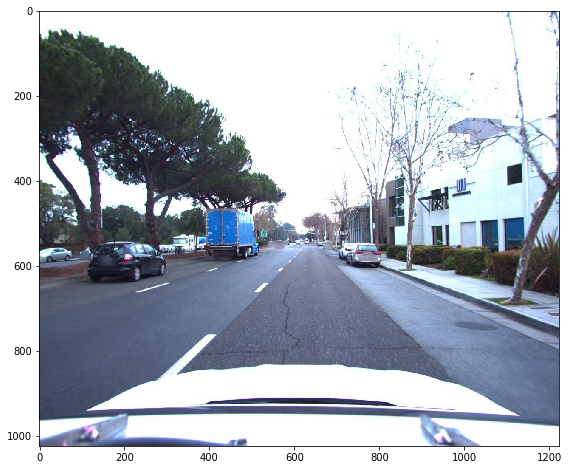

In [7]:
def imread(path, fast_mode=False):
    img = cv2.imread(path)
    if not fast_mode and img is not None and len(img.shape) == 3:
        img = np.array(img[:, :, ::-1])
    return img
img = imread(PATH + 'train_images/host-a004_cam0_1232815252251064006.jpeg')
IMG_SHAPE = img.shape

plt.figure(figsize=(15,8))
plt.imshow(img);

**PredictionString** column contains pose information about all cars  

From the data description:
> The primary data is images of cars and related pose information. The pose information is formatted as strings, as follows:  
>
> `model type, yaw, pitch, roll, x, y, z`  
>
> A concrete example with two cars in the photo:  
>
> `5 0.5 0.5 0.5 0.0 0.0 0.0 32 0.25 0.25 0.25 0.5 0.4 0.7`  

We will need a function to extract these values:

In [8]:
def str2coords(s, names=['id', 'yaw', 'pitch', 'roll', 'x', 'y', 'z']):
    '''
    Input:
        s: PredictionString (e.g. from train dataframe)
        names: array of what to extract from the string
    Output:
        list of dicts with keys from `names`
    '''
    coords = []
    for l in np.array(s.split()).reshape([-1, 7]):
        coords.append(dict(zip(names, l.astype('float'))))
        if 'id' in coords[-1]:
            coords[-1]['id'] = int(coords[-1]['id'])
    return coords

In [9]:
inp = train['PredictionString'][0]
print('Example input:\n', inp)
print()
print('Output:\n', str2coords(inp))

Example input:
 0.5 -2.733 -0.008 1.545 5.576 1.126 20.866 0.5 -0.024 -0.008 1.545 -15.705 1.163 22.421 0.5 -0.004 -0.008 1.545 -14.152 1.267 18.438 0.5 3.13 -0.008 1.545 -27.844 1.293 37.855 0.5 3.129 -0.008 1.545 17.991 1.569 33.513 0.5 -1.573 -0.008 1.545 -3.495 2.132 56.169 0.5 0.081 -0.008 1.545 -9.584 1.192 14.018 0.5 -3.134 -0.008 1.545 1.261 1.309 26.745 0.5 -0.024 -0.008 1.545 -22.353 1.282 22.349 0.5 3.128 -0.008 1.545 -9.788 0.533 31.317 0.5 3.112 -0.008 1.545 29.644 1.821 36.664 0.5 -1.608 -0.008 1.545 -3.747 1.919 46.412 0.5 3.101 -0.008 1.545 22.619 1.089 23.056 0.5 3.097 -0.008 1.545 -15.835 1.514 27.373 0.5 -2.017 -0.008 1.545 -1.036 1.109 11.193 0.5 3.094 -0.008 1.545 24.543 1.596 36.925 0.5 -1.746 -0.008 1.545 -4.406 2.207 80.81

Output:
 [{'id': 0, 'yaw': -2.733, 'pitch': -0.008, 'roll': 1.545, 'x': 5.576, 'y': 1.126, 'z': 20.866}, {'id': 0, 'yaw': -0.024, 'pitch': -0.008, 'roll': 1.545, 'x': -15.705, 'y': 1.163, 'z': 22.421}, {'id': 0, 'yaw': -0.004, 'pitch': -0.008

# Data distributions

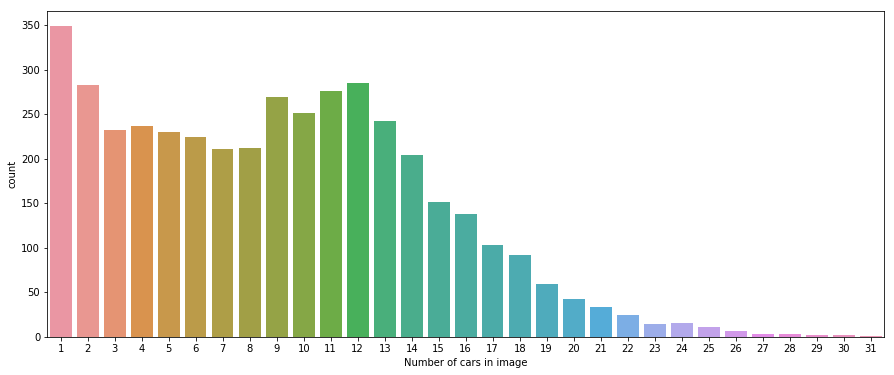

In [10]:
lens = [len(str2coords(s)) for s in train['PredictionString']]

plt.figure(figsize=(15,6))
sns.countplot(lens);
plt.xlabel('Number of cars in image');

DataFrame of all points

In [11]:
points_df = pd.DataFrame()
for col in ['x', 'y', 'z', 'yaw', 'pitch', 'roll']:
    arr = []
    for ps in train['PredictionString']:
        coords = str2coords(ps)
        arr += [c[col] for c in coords]
    points_df[col] = arr

print('len(points_df)', len(points_df))
points_df.head()

len(points_df) 38191


x      y       z    yaw  pitch   roll
0   5.576  1.126  20.866 -2.733 -0.008  1.545
1 -15.705  1.163  22.421 -0.024 -0.008  1.545
2 -14.152  1.267  18.438 -0.004 -0.008  1.545
3 -27.844  1.293  37.855  3.130 -0.008  1.545
4  17.991  1.569  33.513  3.129 -0.008  1.545

In [12]:
print('x max: {}'.format(points_df['x'].max()))
print('x min: {}'.format(points_df['x'].min()))
print('y max: {}'.format(points_df['y'].max()))
print('y min: {}'.format(points_df['y'].min()))
print('z max: {}'.format(points_df['z'].max()))
print('z min: {}'.format(points_df['z'].min()))
print('yaw max: {}'.format(points_df['yaw'].max()))
print('yaw min: {}'.format(points_df['yaw'].min()))
print('pitch max: {}'.format(points_df['pitch'].max()))
print('pitch min: {}'.format(points_df['pitch'].min()))
print('roll max: {}'.format(points_df['roll'].max()))
print('roll min: {}'.format(points_df['roll'].min()))

x max: 52.11
x min: -61.842
y max: 7.359
y min: -2.783
z max: 99.045
z min: 2.231
yaw max: 3.141
yaw min: -3.141
pitch max: 0.016
pitch min: -0.099
roll max: 1.64
roll min: 1.475


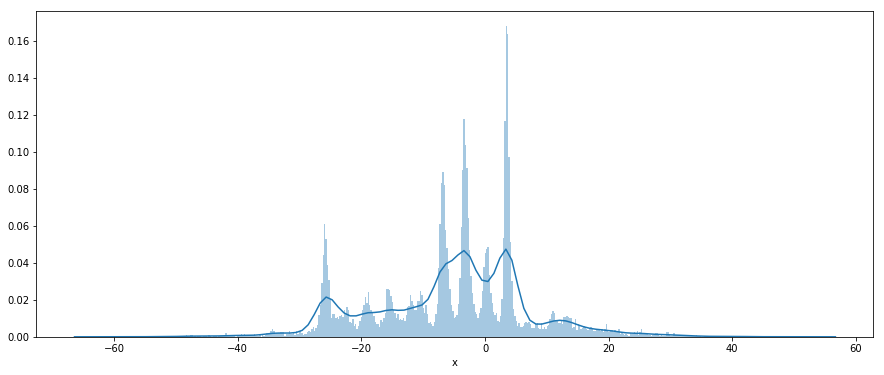

In [13]:
plt.figure(figsize=(15,6))
sns.distplot(points_df['x'], bins=500);
plt.xlabel('x')
plt.show()

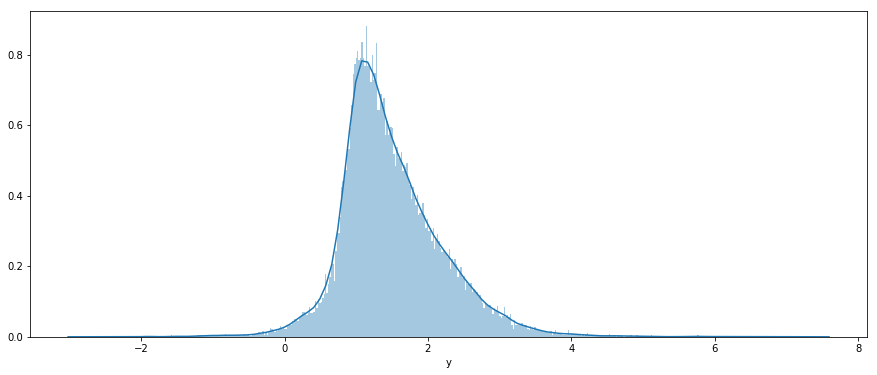

In [14]:
plt.figure(figsize=(15,6))
sns.distplot(points_df['y'], bins=500);
plt.xlabel('y')
plt.show()

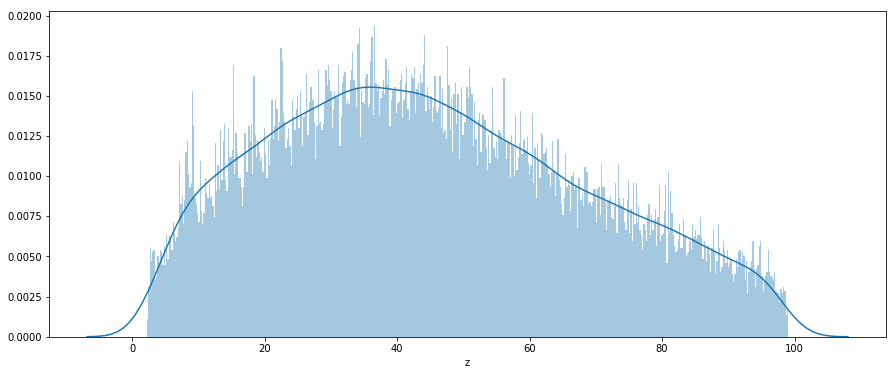

In [15]:
plt.figure(figsize=(15,6))
sns.distplot(points_df['z'], bins=500);
plt.xlabel('z')
plt.show()

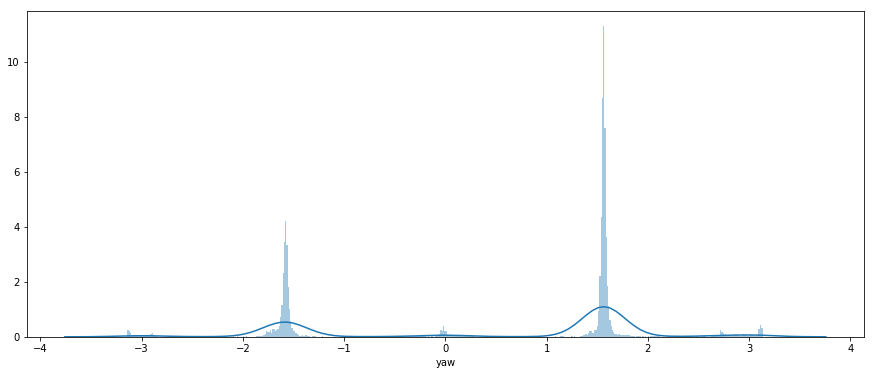

In [16]:
plt.figure(figsize=(15,6))
sns.distplot(points_df['yaw'], bins=500);
plt.xlabel('yaw')
plt.show()

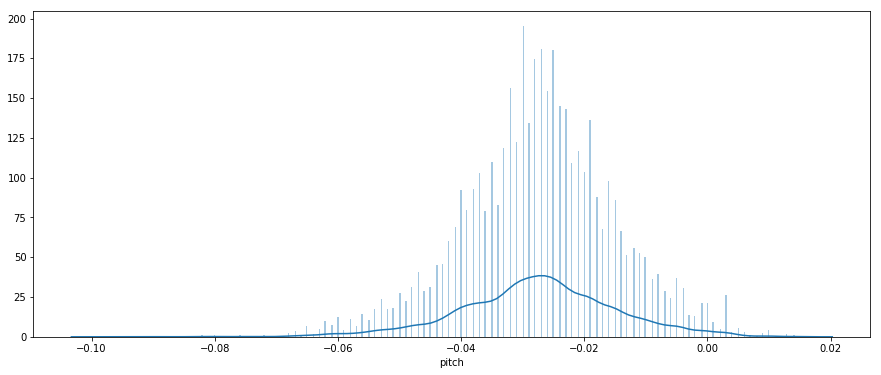

In [17]:
plt.figure(figsize=(15,6))
sns.distplot(points_df['pitch'], bins=500);
plt.xlabel('pitch')
plt.show()

I guess, pitch and yaw are mixed up in this dataset. Pitch cannot be that big. That would mean that cars are upside down.

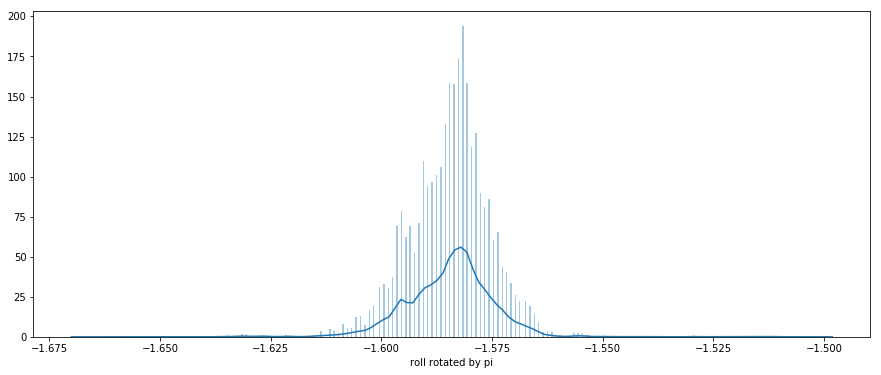

In [18]:
def rotate(x, angle):
    x = x + angle
    x = x - (x + np.pi) // (2 * np.pi) * 2 * np.pi
    return x

plt.figure(figsize=(15,6))
sns.distplot(points_df['roll'].map(lambda x: rotate(x, np.pi)), bins=500);
plt.xlabel('roll rotated by pi')
plt.show()

# 2D Visualization

In [19]:
import ast

In [20]:
np.array(ast.literal_eval(train['CameraIntrinsic'][5]))

array([[1.10905240e+03, 0.00000000e+00, 9.57849065e+02],
       [0.00000000e+00, 1.10905240e+03, 5.39672710e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [21]:
import ast
def get_camera_intrinsic(df, index):
    camera_intrinsic =  np.array(ast.literal_eval(train['CameraIntrinsic'].iloc[index]))
    return camera_intrinsic

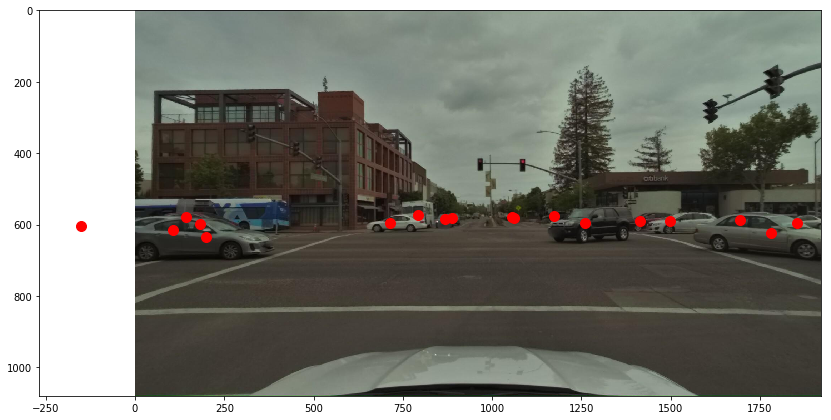

In [22]:
def get_img_coords(s, camera_matrix):
    '''
    Input is a PredictionString (e.g. from train dataframe)
    Output is two arrays:
        xs: x coordinates in the image (row)
        ys: y coordinates in the image (column)
    '''
    coords = str2coords(s)
    xs = [c['x'] for c in coords]
    ys = [c['y'] for c in coords]
    zs = [c['z'] for c in coords]
    P = np.array(list(zip(xs, ys, zs))).T
    img_p = np.dot(camera_matrix, P).T
    img_p[:, 0] /= img_p[:, 2]
    img_p[:, 1] /= img_p[:, 2]
    img_xs = img_p[:, 0]
    img_ys = img_p[:, 1]
    img_zs = img_p[:, 2] # z = Distance from the camera
    return img_xs, img_ys

plt.figure(figsize=(14,14))
plt.imshow(imread(PATH + 'train_images/' + train['ImageId'][5] + '.jpeg'))
#camera_matrix = np.array([[2304.5479, 0,  1686.2379],
#                          [0, 2305.8757, 1354.9849],
#                          [0, 0, 1]], dtype=np.float32)
plt.scatter(*get_img_coords(train['PredictionString'][5], get_camera_intrinsic(train,5)), color='red', s=100);

One point is out of image!

Let's look at the distribution of all points. Image is here just for reference.

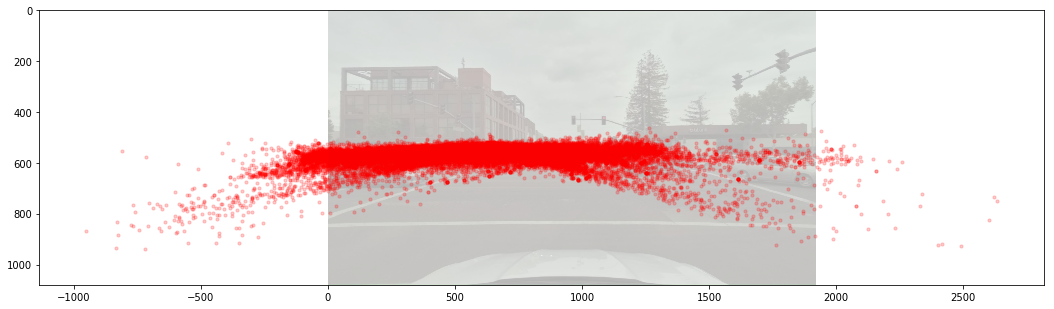

In [23]:
xs, ys = [], []

for index, ps in enumerate(train['PredictionString']):
    x, y = get_img_coords(ps, get_camera_intrinsic(train, index))
    xs += list(x)
    ys += list(y)

plt.figure(figsize=(18,18))
plt.imshow(imread(PATH + 'train_images/' + train['ImageId'][5] + '.jpeg'), alpha=0.3)
plt.scatter(xs, ys, color='red', s=10, alpha=0.2);

Many points are outside!

Let's look at this distribution "from the sky"

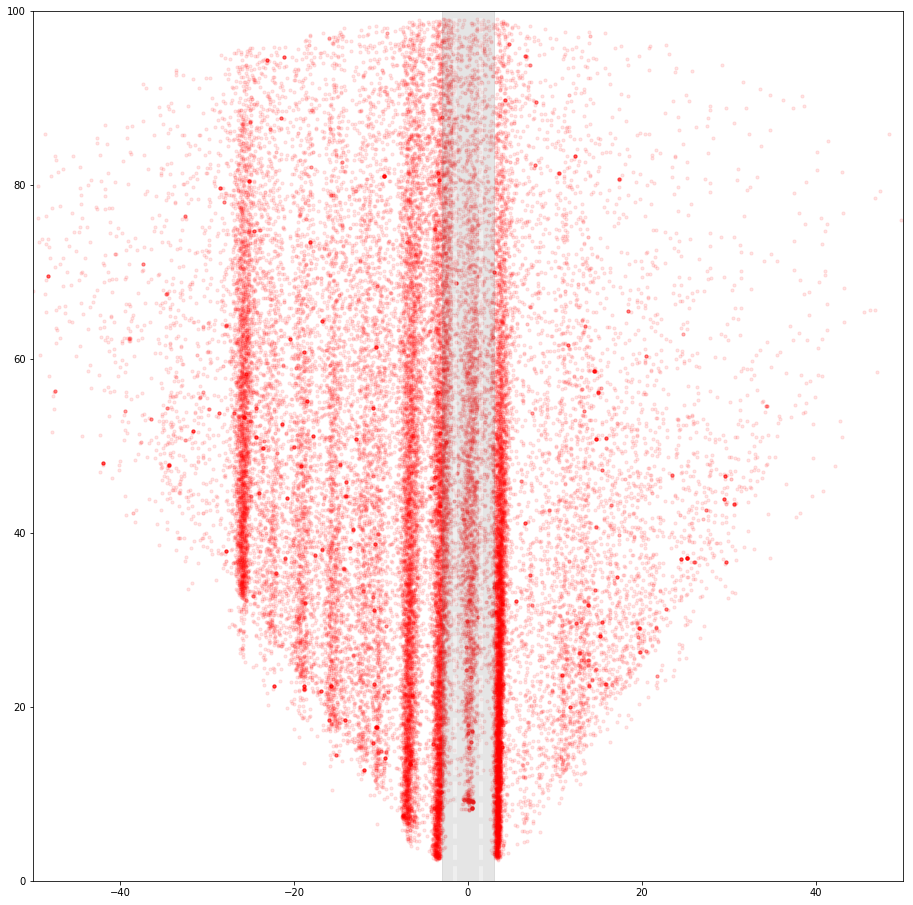

In [24]:
# Road points
road_width = 3
road_xs = [-road_width, road_width, road_width, -road_width, -road_width]
road_ys = [0, 0, 500, 500, 0]

plt.figure(figsize=(16,16))
plt.axes().set_aspect(1)
plt.xlim(-50,50)
plt.ylim(0,100)

# View road
plt.fill(road_xs, road_ys, alpha=0.2, color='gray')
plt.plot([road_width/2,road_width/2], [0,100], alpha=0.4, linewidth=4, color='white', ls='--')
plt.plot([-road_width/2,-road_width/2], [0,100], alpha=0.4, linewidth=4, color='white', ls='--')
# View cars
plt.scatter(points_df['x'], np.sqrt(points_df['z']**2 + points_df['y']**2), color='red', s=10, alpha=0.1);

3d distribution of points:

In [25]:
fig = px.scatter_3d(points_df, x='x', y='y', z='z',color='yaw', range_x=(-50,50), range_y=(0,50), range_z=(0,250), opacity=0.1)
fig.show()

1) `x` is measured from left to right  
2) I thought that `y` is the distance from the car and `z` is height above the road. Looks like this is not the case.  

Let's look how good these points lay in one plane  
Try to predict `y` knowing `x, z`:

In [26]:
zy_slope = LinearRegression()
X = points_df[['z']]
y = points_df['y']
zy_slope.fit(X, y)
print('MAE without x:', mean_absolute_error(y, zy_slope.predict(X)))

# Will use this model later
xzy_slope = LinearRegression()
X = points_df[['x', 'z']]
y = points_df['y']
xzy_slope.fit(X, y)
print('MAE with x:', mean_absolute_error(y, xzy_slope.predict(X)))

print('\ndy/dx = {:.3f}\ndy/dz = {:.3f}'.format(*xzy_slope.coef_))

MAE without x: 0.41226224165812114
MAE with x: 0.3501234588331446

dy/dx = -0.025
dy/dz = 0.013


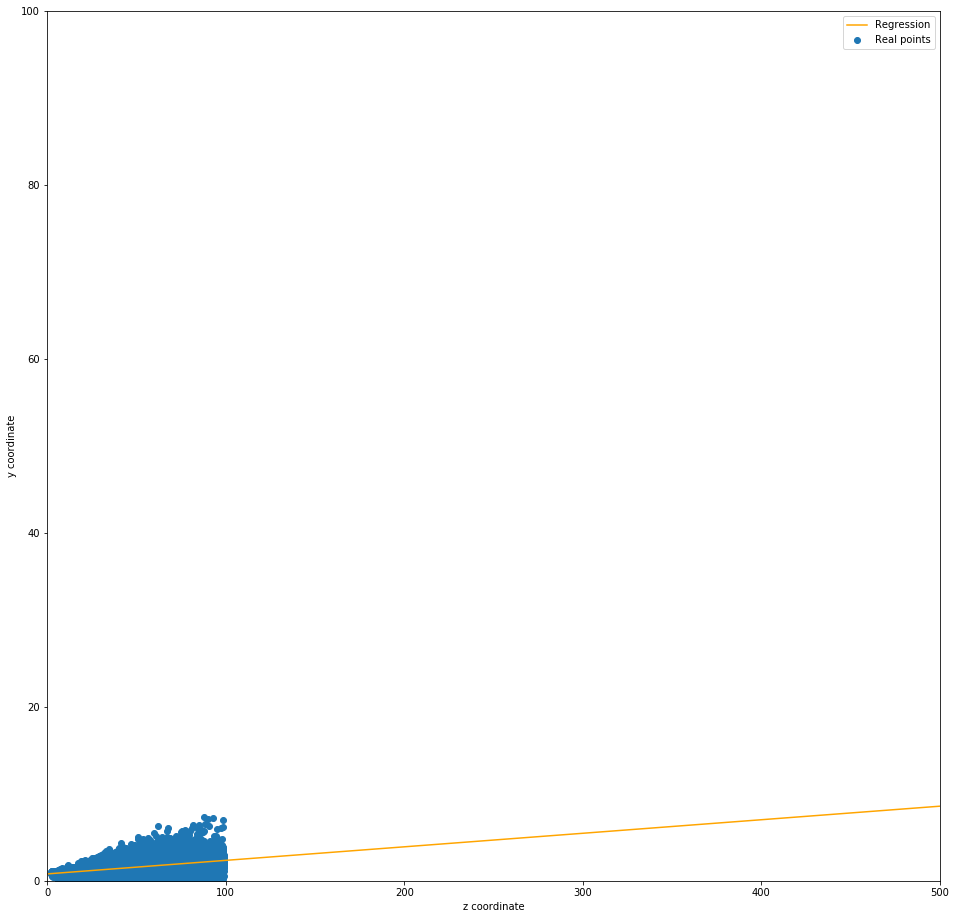

In [27]:
plt.figure(figsize=(16,16))
plt.xlim(0,500)
plt.ylim(0,100)
plt.scatter(points_df['z'], points_df['y'], label='Real points')
X_line = np.linspace(0,500, 10)
plt.plot(X_line, zy_slope.predict(X_line.reshape(-1, 1)), color='orange', label='Regression')
plt.legend()
plt.xlabel('z coordinate')
plt.ylabel('y coordinate');

# 3D Visualization
Used code from https://www.kaggle.com/zstusnoopy/visualize-the-location-and-3d-bounding-box-of-car, but made it one function

In [28]:
from math import sin, cos

# convert euler angle to rotation matrix
def euler_to_Rot(yaw, pitch, roll):
    Y = np.array([[cos(yaw), 0, sin(yaw)],
                  [0, 1, 0],
                  [-sin(yaw), 0, cos(yaw)]])
    P = np.array([[1, 0, 0],
                  [0, cos(pitch), -sin(pitch)],
                  [0, sin(pitch), cos(pitch)]])
    R = np.array([[cos(roll), -sin(roll), 0],
                  [sin(roll), cos(roll), 0],
                  [0, 0, 1]])
    return np.dot(Y, np.dot(P, R))

In [29]:
def draw_line(image, points):
    color = (255, 0, 0)
    cv2.line(image, tuple(points[0][:2]), tuple(points[3][:2]), color, 16)
    cv2.line(image, tuple(points[0][:2]), tuple(points[1][:2]), color, 16)
    cv2.line(image, tuple(points[1][:2]), tuple(points[2][:2]), color, 16)
    cv2.line(image, tuple(points[2][:2]), tuple(points[3][:2]), color, 16)
    return image


def draw_points(image, points):
    for (p_x, p_y, p_z) in points:
        cv2.circle(image, (p_x, p_y), int(1000 / p_z), (0, 255, 0), -1)
#         if p_x > image.shape[1] or p_y > image.shape[0]:
#             print('Point', p_x, p_y, 'is out of image with shape', image.shape)
    return image

In [30]:
def visualize(img, coords, camera_intrinsic):
    # You will also need functions from the previous cells
    x_l = 1.02
    y_l = 0.80
    z_l = 2.31
    
    img = img.copy()
    for point in coords:
        # Get values
        x, y, z = point['x'], point['y'], point['z']
        #yaw, pitch, roll = -point['pitch'], -point['yaw'], -point['roll']
        yaw, pitch, roll = point['yaw'], 0, 0
        # Math
        Rt = np.eye(4)
        t = np.array([x, y, z])
        Rt[:3, 3] = t
        Rt[:3, :3] = euler_to_Rot(yaw, pitch, roll).T
        Rt = Rt[:3, :]
        P = np.array([[x_l, -y_l, -z_l, 1],
                      [x_l, -y_l, z_l, 1],
                      [-x_l, -y_l, z_l, 1],
                      [-x_l, -y_l, -z_l, 1],
                      [0, 0, 0, 1]]).T
        img_cor_points = np.dot(camera_intrinsic, np.dot(Rt, P))
        img_cor_points = img_cor_points.T
        img_cor_points[:, 0] /= img_cor_points[:, 2]
        img_cor_points[:, 1] /= img_cor_points[:, 2]
        img_cor_points = img_cor_points.astype(int)
        # Drawing
        img = draw_line(img, img_cor_points)
        img = draw_points(img, img_cor_points[-1:])
    
    return img

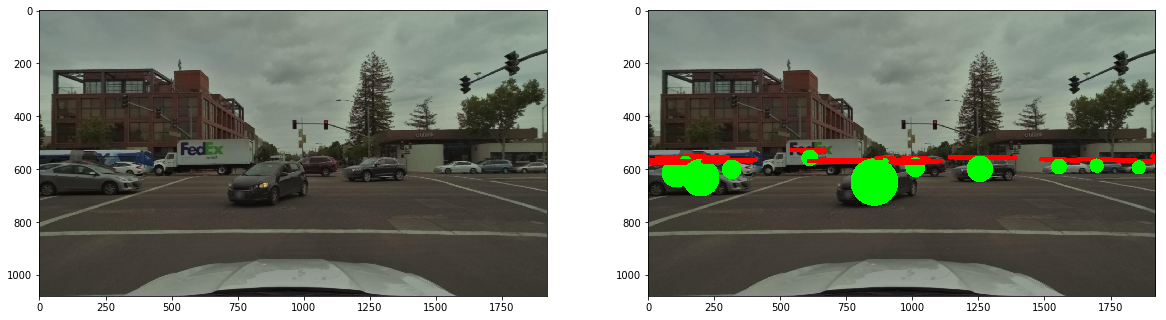

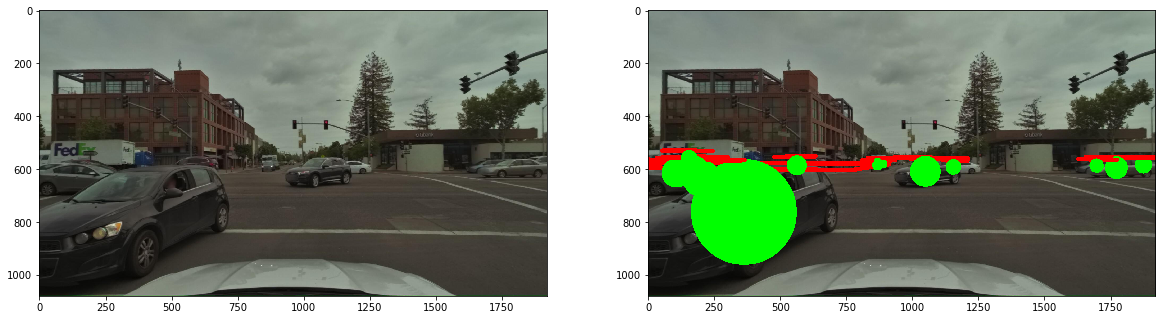

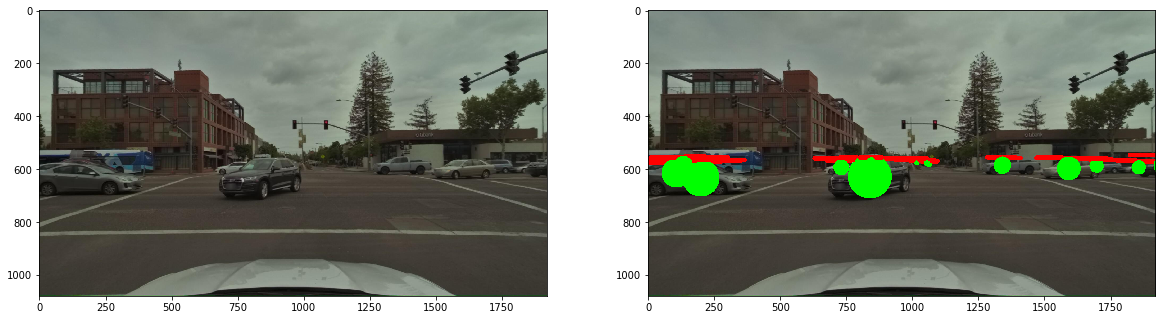

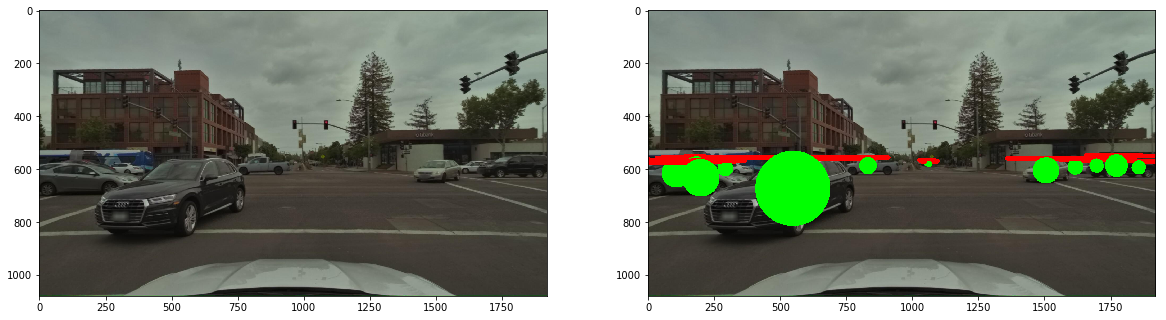

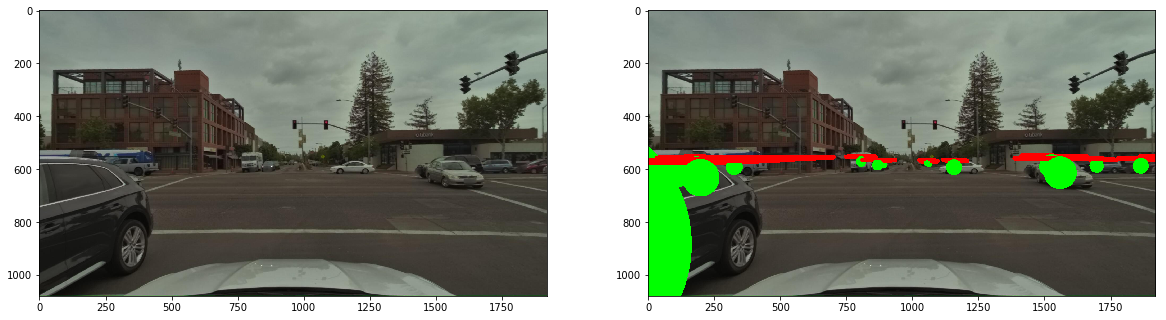

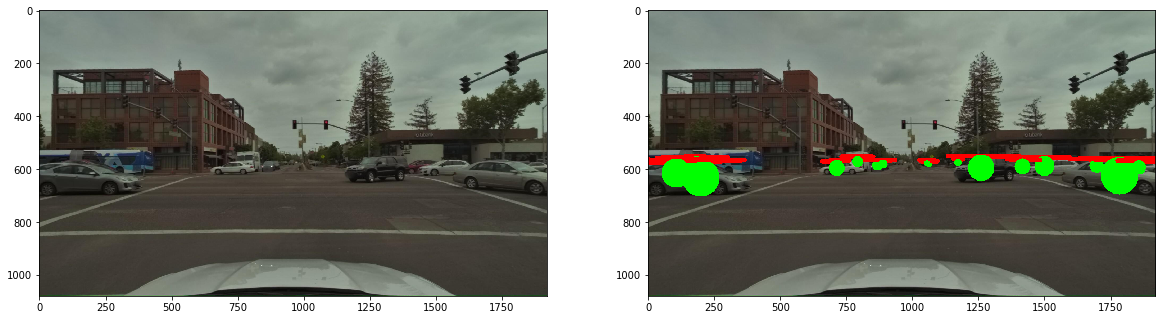

In [31]:
n_rows = 6

for idx in range(n_rows):
    fig, axes = plt.subplots(1, 2, figsize=(20,20))
    img = imread(PATH + 'train_images/' + train['ImageId'].iloc[idx] + '.jpeg')
    axes[0].imshow(img)
    img_vis = visualize(img, str2coords(train['PredictionString'].iloc[idx]), get_camera_intrinsic(train, idx))
    axes[1].imshow(img_vis)
    plt.show()

# Image preprocessing

In [32]:
IMG_WIDTH = 1024
IMG_HEIGHT = IMG_WIDTH // 16 * 5
MODEL_SCALE = 8

def _regr_preprocess(regr_dict, flip=False):
    if flip:
        raise Exception('flip is True')
        for k in ['x', 'yaw', 'roll']:
            regr_dict[k] = -regr_dict[k]
    for name in ['x', 'y', 'z']:
        regr_dict[name] = regr_dict[name] / 100
    #regr_dict['roll'] = rotate(regr_dict['roll'], np.pi)
    regr_dict['yaw_sin'] = sin(regr_dict['yaw'])
    regr_dict['yaw_cos'] = cos(regr_dict['yaw'])
    regr_dict.pop('yaw')
    regr_dict.pop('pitch')
    regr_dict.pop('roll')
    regr_dict.pop('id')
    return regr_dict

def _regr_back(regr_dict):
    for name in ['x', 'y', 'z']:
        regr_dict[name] = regr_dict[name] * 100
    #regr_dict['roll'] = rotate(regr_dict['roll'], -np.pi)
    
    yaw_sin = regr_dict['yaw_sin'] / np.sqrt(regr_dict['yaw_sin']**2 + regr_dict['yaw_cos']**2)
    yaw_cos = regr_dict['yaw_cos'] / np.sqrt(regr_dict['yaw_sin']**2 + regr_dict['yaw_cos']**2)
    regr_dict['yaw'] = np.arccos(yaw_cos) * np.sign(yaw_sin)
    return regr_dict

def preprocess_image(img, flip=False):
    img = img[img.shape[0] // 2:]
    bg = np.ones_like(img) * img.mean(1, keepdims=True).astype(img.dtype)
    bg = bg[:, :img.shape[1] // 6]
    img = np.concatenate([bg, img, bg], 1)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    if flip:
        img = img[:,::-1]
    return (img / 255).astype('float32')

def get_mask_and_regr(img, labels, camera_matrix, flip=False):
    if flip:
        raise Exception('flip is True')
    mask = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE], dtype='float32')
    regr_names = ['x', 'y', 'z', 'yaw']
    image_coords = []
    regr = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE, 5], dtype='float32')
    coords = str2coords(labels)
    xs, ys = get_img_coords(labels, camera_matrix)
    for x, y, regr_dict in zip(xs, ys, coords):
        x, y = y, x
        x = (x - img.shape[0] // 2) * IMG_HEIGHT / (img.shape[0] // 2) / MODEL_SCALE
        x = np.round(x).astype('int')
        y = (y + img.shape[1] // 6) * IMG_WIDTH / (img.shape[1] * 4/3) / MODEL_SCALE
        y = np.round(y).astype('int')
        image_coords += [(x,y)]
        if x >= 0 and x < IMG_HEIGHT // MODEL_SCALE and y >= 0 and y < IMG_WIDTH // MODEL_SCALE:
            mask[x, y] = 1
            regr_dict = _regr_preprocess(regr_dict, flip)
            regr[x, y] = [regr_dict[n] for n in sorted(regr_dict)]
    if flip:
        mask = np.array(mask[:,::-1])
        regr = np.array(regr[:,::-1])
    if np.sum(mask) == 0:
        print('mask sum is 0')
        print('image coords: {}'.format(image_coords))
    return mask, regr

img.shape (320, 1024, 3) std: 0.10481986
mask.shape (40, 128) std: 0.05752641
regr.shape (40, 128, 5) std: 0.027723923


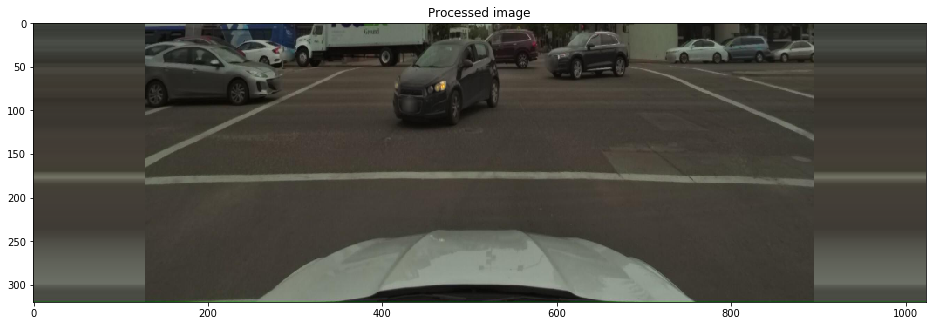

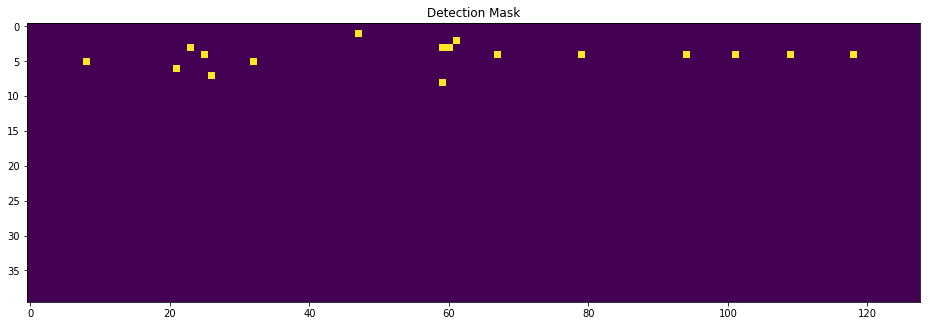

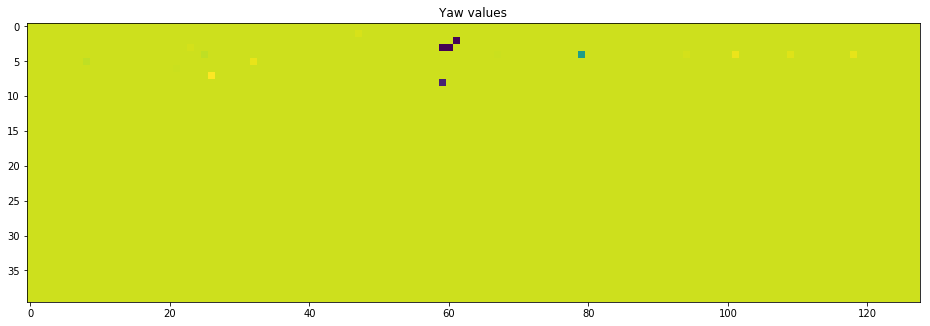

In [33]:
img0 = imread(PATH + 'train_images/' + train['ImageId'][0] + '.jpeg')
img = preprocess_image(img0)

mask, regr = get_mask_and_regr(img0, train['PredictionString'][0], get_camera_intrinsic(train, 0))

print('img.shape', img.shape, 'std:', np.std(img))
print('mask.shape', mask.shape, 'std:', np.std(mask))
print('regr.shape', regr.shape, 'std:', np.std(regr))

plt.figure(figsize=(16,16))
plt.title('Processed image')
plt.imshow(img)
plt.show()

plt.figure(figsize=(16,16))
plt.title('Detection Mask')
plt.imshow(mask)
plt.show()

plt.figure(figsize=(16,16))
plt.title('Yaw values')
plt.imshow(regr[:,:,-2])
plt.show()

Define functions to convert back from 2d map to 3d coordinates and angles

In [34]:
DISTANCE_THRESH_CLEAR = 2

def convert_3d_to_2d(x, y, z, camera_intrinsic):   #fx = 2304.5479, fy = 2305.8757, cx = 1686.2379, cy = 1354.9849):
    # stolen from https://www.kaggle.com/theshockwaverider/eda-visualization-baseline
    fx = camera_intrinsic[0][0]
    fy = camera_intrinsic[1][1]
    cx = camera_intrinsic[0][2]
    cy = camera_intrinsic[1][2]
    return x * fx / z + cx, y * fy / z + cy

def optimize_xy(r, c, x0, y0, z0, camera_intrinsic, flipped=False):
    def distance_fn(xyz):
        x, y, z = xyz
        xx = -x if flipped else x
        slope_err = (xzy_slope.predict([[xx,z]])[0] - y)**2
        x, y = convert_3d_to_2d(x, y, z, camera_intrinsic)
        y, x = x, y
        x = (x - IMG_SHAPE[0] // 2) * IMG_HEIGHT / (IMG_SHAPE[0] // 2) / MODEL_SCALE
        y = (y + IMG_SHAPE[1] // 6) * IMG_WIDTH / (IMG_SHAPE[1] * 4 / 3) / MODEL_SCALE
        return max(0.2, (x-r)**2 + (y-c)**2) + max(0.4, slope_err)
    
    res = minimize(distance_fn, [x0, y0, z0], method='Powell')
    x_new, y_new, z_new = res.x
    return x_new, y_new, z_new

def clear_duplicates(coords):
    for c1 in coords:
        xyz1 = np.array([c1['x'], c1['y'], c1['z']])
        for c2 in coords:
            xyz2 = np.array([c2['x'], c2['y'], c2['z']])
            distance = np.sqrt(((xyz1 - xyz2)**2).sum())
            if distance < DISTANCE_THRESH_CLEAR:
                if c1['confidence'] < c2['confidence']:
                    c1['confidence'] = -1
    return [c for c in coords if c['confidence'] > 0]

def extract_coords(prediction, camera_intrinsic, flipped=False):
    logits = prediction[0]
    regr_output = prediction[1:]
    points = np.argwhere(logits > 0)
    col_names = sorted(['x', 'y', 'z', 'yaw_sin', 'yaw_cos'])
    coords = []
    for r, c in points:
        regr_dict = dict(zip(col_names, regr_output[:, r, c]))
        coords.append(_regr_back(regr_dict))
        coords[-1]['confidence'] = 1 / (1 + np.exp(-logits[r, c]))
        #coords[-1]['x'], coords[-1]['y'], coords[-1]['z'] = \
        #        optimize_xy(r, c,
        #                    coords[-1]['x'],
        #                    coords[-1]['y'],
        #                    coords[-1]['z'], camera_intrinsic, flipped)
    coords = clear_duplicates(coords)
    return coords

def coords2str(coords, names=['yaw', 'x', 'y', 'z', 'confidence']):
    s = []
    for c in coords:
        for n in names:
            s.append(str(c.get(n, 0)))
    return ' '.join(s)

Ensure that all the forward and back transformations work consistently

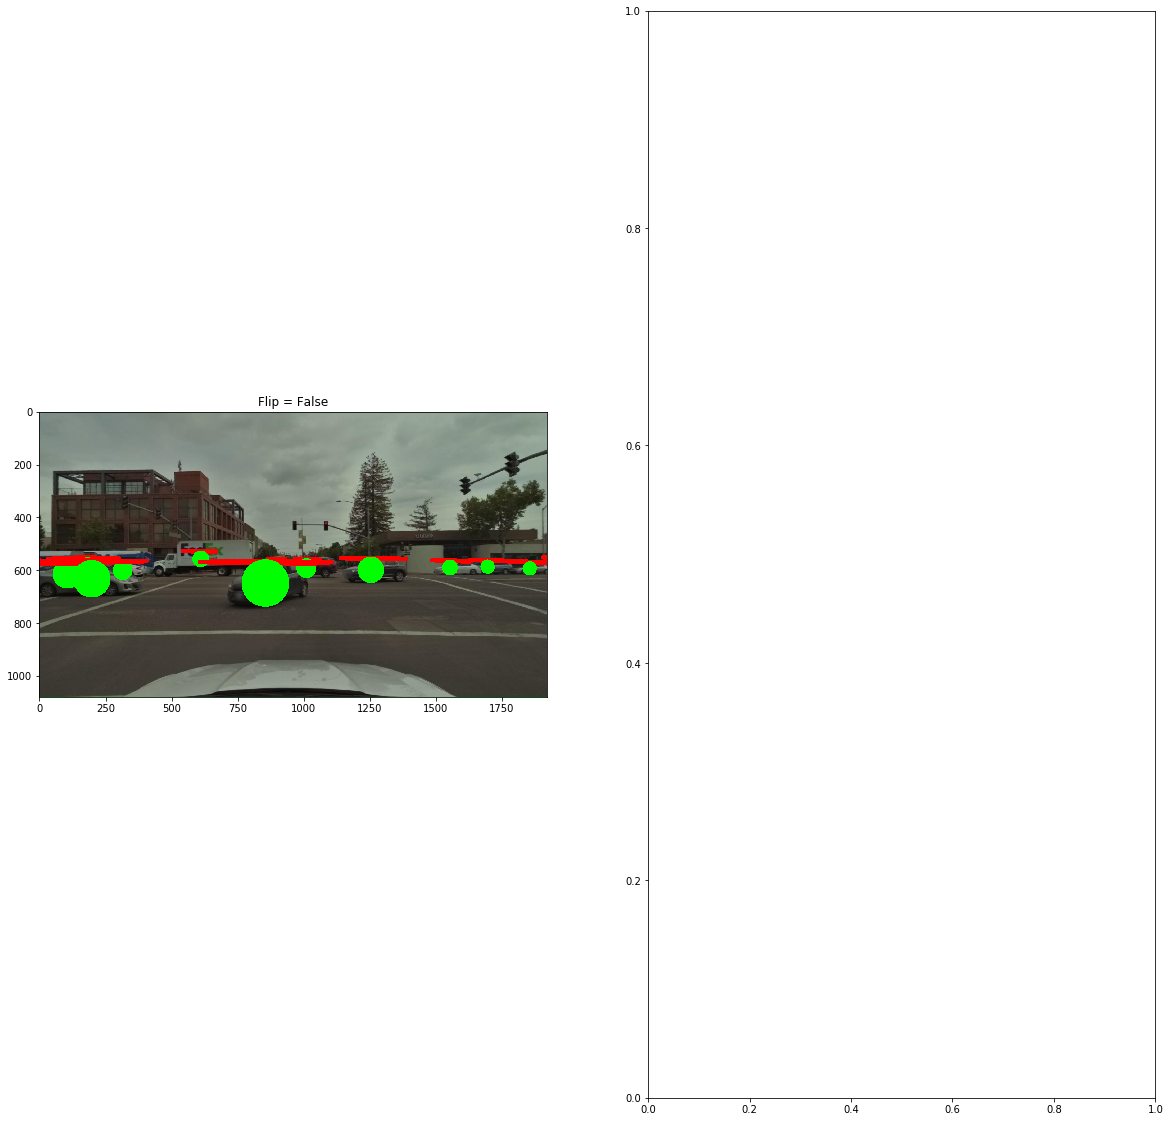

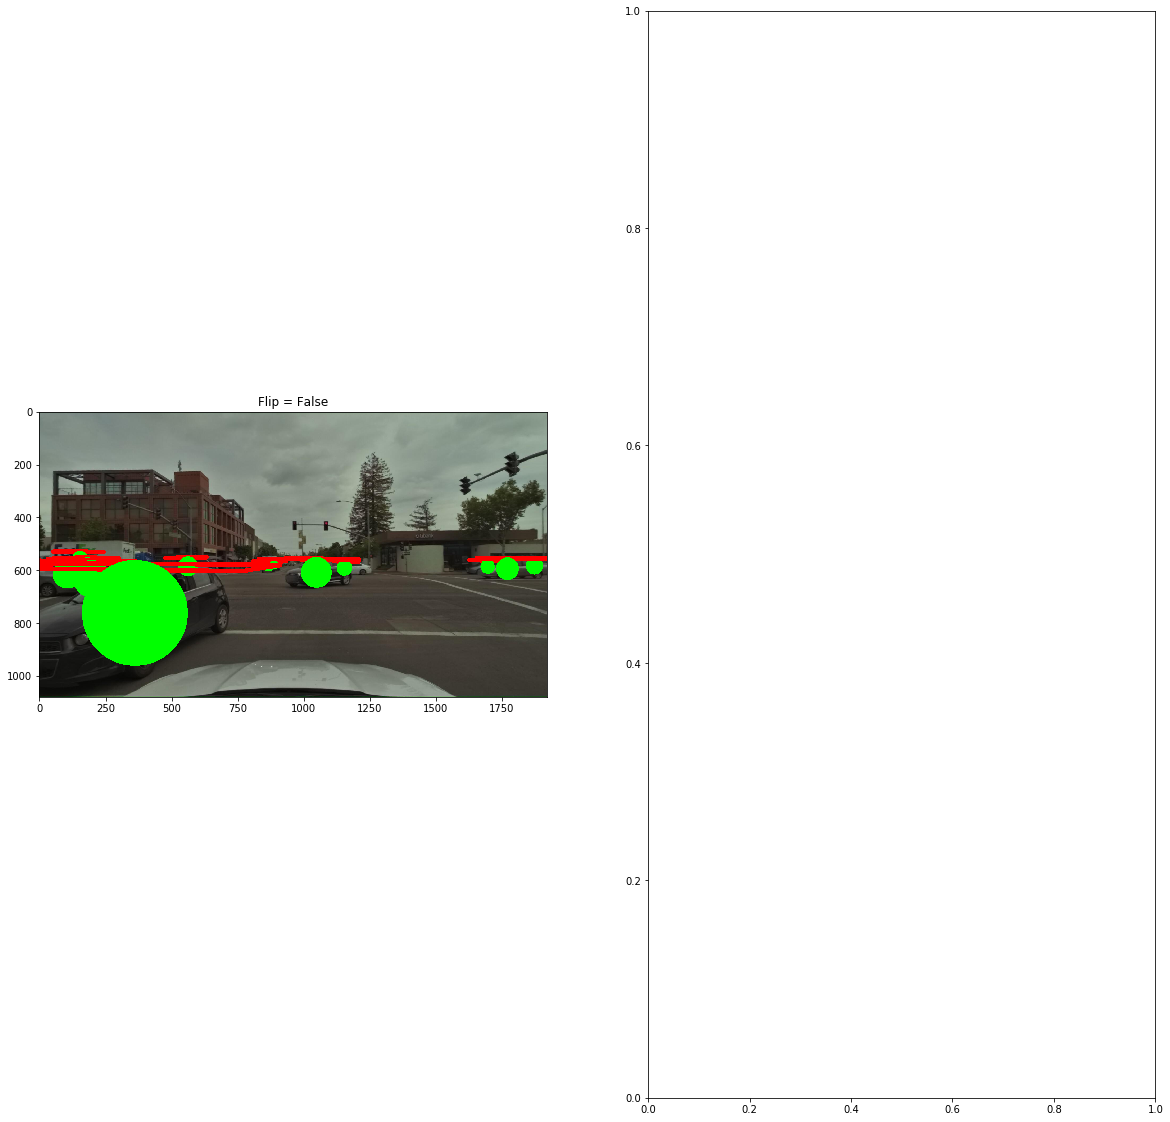

In [35]:
for idx in range(2):
    fig, axes = plt.subplots(1, 2, figsize=(20,20))
    
    for ax_i in range(1):
        img0 = imread(PATH + 'train_images/' + train['ImageId'].iloc[idx] + '.jpeg')
        if ax_i == 1:
            img0 = img0[:,::-1]
        img = preprocess_image(img0, ax_i==1)
        mask, regr = get_mask_and_regr(img0, train['PredictionString'][idx], get_camera_intrinsic(train, idx), ax_i==1)
        regr = np.rollaxis(regr, 2, 0)
        coords = extract_coords(np.concatenate([mask[None], regr], 0), get_camera_intrinsic(train, idx), ax_i==1)
        
        axes[ax_i].set_title('Flip = {}'.format(ax_i==1))
        axes[ax_i].imshow(visualize(img0, coords, get_camera_intrinsic(train, idx)))
    plt.show()

# PyTorch Dataset

In [36]:
class CarDataset(Dataset):
    """Car dataset."""

    def __init__(self, dataframe, root_dir, training=True, transform=None):
        self.df = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.training = training

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        # Get image name
        filename, labels = self.df[['ImageId', 'PredictionString']].values[idx]
        img_name = self.root_dir.format(filename)
        
        # Augmentation
        flip = False
        #if self.training:
        #    flip = np.random.randint(10) == 1
        
        # Read image
        img0 = imread(img_name, True)
        img = preprocess_image(img0, flip=flip)
        img = np.rollaxis(img, 2, 0)
        
        # Get mask and regression maps
        mask, regr = get_mask_and_regr(img0, labels, get_camera_intrinsic(self.df, idx), flip=flip)
        regr = np.rollaxis(regr, 2, 0)
        
        if(np.sum(mask) == 0):
            print('idx is {}'.format(idx))
            print('camera intrinsic: {}'.format(get_camera_intrinsic(self.df, idx)))
            print('mask sum: {}'.format(np.sum(mask)))
            print('filename is: {}'.format(filename))
            print('filename raw: {}'.format(self.df[['ImageId']].values[idx]))
            
            raise Exception('mask sum is 0')
        
        return [img, mask, regr]

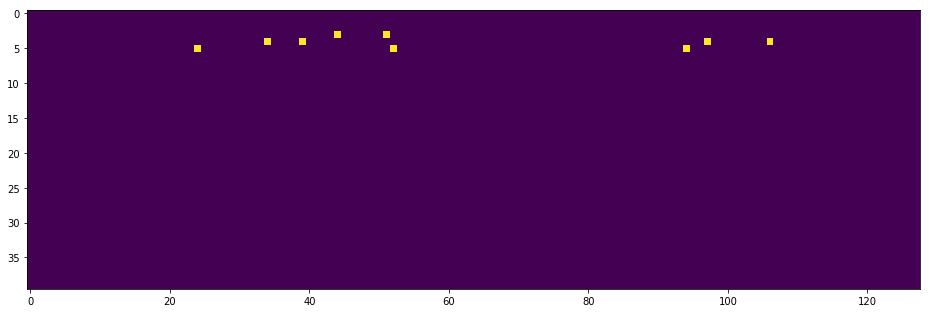

In [37]:
img0 = imread(PATH + 'train_images/' + train['ImageId'].iloc[1834] + '.jpeg')
mask, regr = get_mask_and_regr(img0, train['PredictionString'].iloc[1834], get_camera_intrinsic(train, train.index.get_loc(1834)))
if np.sum(mask) == 0:
    print('removing image {} from dataset'.format(train['ImageId'].iloc[1834]))
    train.drop(index = i, inplace = True)
    

plt.figure(figsize=(16,16))
plt.imshow(mask)
plt.show()


In [38]:
train_images_dir = PATH + 'train_images/{}.jpeg'
test_images_dir = PATH + 'test_images/{}.jpeg'

df_train, df_dev = train_test_split(train, test_size=0.2, random_state=42)
#df_test = test


In [39]:
for i in df_train.index:
    img0 = imread(PATH + 'train_images/' + df_train['ImageId'][i] + '.jpeg')
    mask, regr = get_mask_and_regr(img0, df_train['PredictionString'][i], get_camera_intrinsic(df_train, df_train.index.get_loc(i)))
    if np.sum(mask) == 0:
        print('removing image {} from dataset'.format(df_train['ImageId'][i]))
        df_train = df_train.drop(index = i)

mask sum is 0
image coords: [(7, 157)]
removing image host-a006_cam0_1236038152250935006 from dataset
mask sum is 0
image coords: [(-1, 52)]
removing image host-a101_cam0_1241561155450000006 from dataset
mask sum is 0
image coords: [(-1, 51)]
removing image host-a101_cam0_1241561154450000006 from dataset
mask sum is 0
image coords: [(-1, 58), (-1, 53)]
removing image host-a102_cam0_1241878216450000006 from dataset
mask sum is 0
image coords: [(18, -29)]
removing image host-a101_cam0_1241216107350000006 from dataset
mask sum is 0
image coords: [(-1, 47), (-1, 44)]
removing image host-a102_cam0_1242510615449319006 from dataset
mask sum is 0
image coords: [(-1, 55), (-1, 64)]
removing image host-a102_cam0_1241878217450000006 from dataset
mask sum is 0
image coords: [(-1, 66)]
removing image host-a011_cam0_1234031764251142006 from dataset
mask sum is 0
image coords: [(-1, 53)]
removing image host-a101_cam0_1241561156450000006 from dataset
mask sum is 0
image coords: [(12, -2)]
removing ima

In [40]:
for i in df_dev.index:
    img0 = imread(PATH + 'train_images/' + df_dev['ImageId'][i] + '.jpeg')
    mask, regr = get_mask_and_regr(img0, df_dev['PredictionString'][i], get_camera_intrinsic(df_dev, df_dev.index.get_loc(i)))
    if np.sum(mask) == 0:
        print('removing image {} from dataset'.format(df_dev['ImageId'][i]))
        df_dev = df_dev.drop(index = i)

mask sum is 0
image coords: [(5, 140)]
removing image host-a004_cam0_1234047745351064006 from dataset
mask sum is 0
image coords: [(-2, 66)]
removing image host-a011_cam0_1234031765251142006 from dataset
mask sum is 0
image coords: [(7, 140)]
removing image host-a004_cam0_1234047746351064006 from dataset


In [41]:
len(df_dev)

839

In [42]:
len(df_train)

3356

In [43]:
# Create dataset objects
train_dataset = CarDataset(df_train, train_images_dir, training=True)
dev_dataset = CarDataset(df_dev, train_images_dir, training=False)
#test_dataset = CarDataset(df_test, test_images_dir, training=False)

Show some generated examples

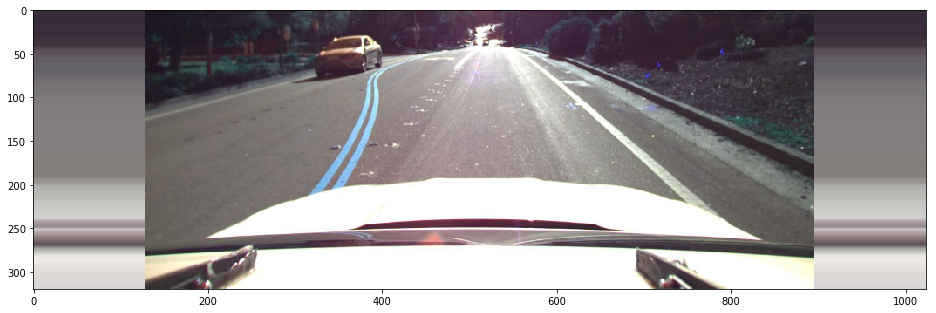

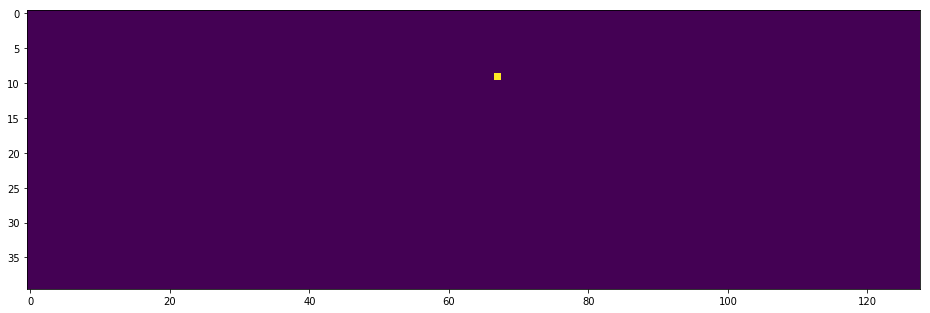

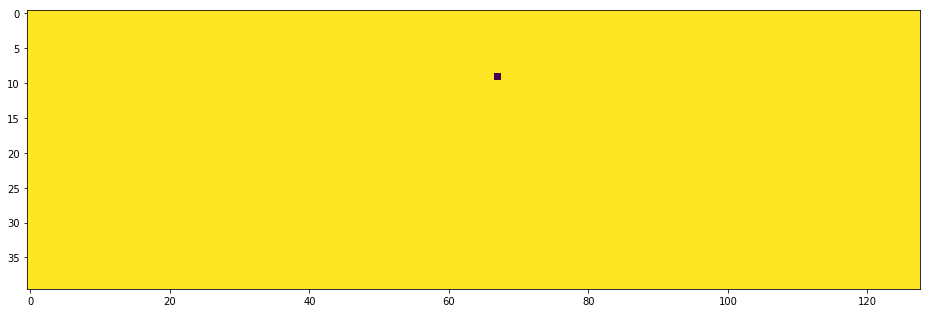

In [44]:
img, mask, regr = train_dataset[0]

plt.figure(figsize=(16,16))
plt.imshow(np.rollaxis(img, 0, 3))
plt.show()

plt.figure(figsize=(16,16))
plt.imshow(mask)
plt.show()

plt.figure(figsize=(16,16))
plt.imshow(regr[-2])
plt.show()

In [45]:
BATCH_SIZE = 2

# Create data generators - they will produce batches
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
dev_loader = DataLoader(dataset=dev_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
#test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# PyTorch Model

In [46]:
!pip install efficientnet-pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp36-none-any.whl size=16032 sha256=2be6448ce0471c2be8d4f561c534c5e8e64c49e985dfa166072b3dedf76bf34a
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch


In [47]:
from efficientnet_pytorch import EfficientNet

In [48]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2=None):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        # for padding issues, see 
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        
        if x2 is not None:
            x = torch.cat([x2, x1], dim=1)
        else:
            x = x1
        x = self.conv(x)
        return x

def get_mesh(batch_size, shape_x, shape_y):
    mg_x, mg_y = np.meshgrid(np.linspace(0, 1, shape_y), np.linspace(0, 1, shape_x))
    mg_x = np.tile(mg_x[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
    mg_y = np.tile(mg_y[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
    mesh = torch.cat([torch.tensor(mg_x).to(device), torch.tensor(mg_y).to(device)], 1)
    return mesh

In [49]:
class MyUNet(nn.Module):
    '''Mixture of previous classes'''
    def __init__(self, n_classes):
        super(MyUNet, self).__init__()
        self.base_model = EfficientNet.from_pretrained('efficientnet-b5')
        
        self.conv0 = double_conv(5, 64)
        self.conv1 = double_conv(64, 128)
        self.conv2 = double_conv(128, 512)
        self.conv3 = double_conv(512, 1024)
        
        self.mp = nn.MaxPool2d(2)
        
        #self.up1 = up(1282 + 1024, 512)
        self.up1 = up(2050 + 1024, 512)
        self.up2 = up(512 + 512, 256)
        self.outc = nn.Conv2d(256, n_classes, 1)

    def forward(self, x):
        batch_size = x.shape[0]
        mesh1 = get_mesh(batch_size, x.shape[2], x.shape[3])
        x0 = torch.cat([x, mesh1], 1)
        x1 = self.mp(self.conv0(x0))
        x2 = self.mp(self.conv1(x1))
        x3 = self.mp(self.conv2(x2))
        x4 = self.mp(self.conv3(x3))
        
        x_center = x[:, :, :, IMG_WIDTH // 8: -IMG_WIDTH // 8]
        feats = self.base_model.extract_features(x_center)
        #print('feats shape: {}'.format(feats.shape))
        bg = torch.zeros([feats.shape[0], feats.shape[1], feats.shape[2], feats.shape[3] // 8]).to(device)
        feats = torch.cat([bg, feats, bg], 3)
        
        # Add positional info
        mesh2 = get_mesh(batch_size, feats.shape[2], feats.shape[3])
        feats = torch.cat([feats, mesh2], 1)
        
        x = self.up1(feats, x4)
        x = self.up2(x, x3)
        x = self.outc(x)
        return x

In [50]:
# Gets the GPU if there is one, otherwise the cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

n_epochs = 10

model = MyUNet(6).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=max(n_epochs, 10) * len(train_loader) // 3, gamma=0.1)

cuda


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth" to /root/.cache/torch/checkpoints/efficientnet-b5-b6417697.pth
100%|██████████| 117M/117M [00:04<00:00, 29.2MB/s] 


Loaded pretrained weights for efficientnet-b5


# Training

In [51]:
#torch.manual_seed(5)

In [52]:
def criterion(prediction, mask, regr, size_average=True):
    # Binary mask loss
    #if(torch.sum(torch.isnan(mask)) > 0):
    #   print('nans in mask')
    #if(torch.sum(torch.isnan(regr)) > 0):
    #   print('nans in regr')
    pred_mask = torch.sigmoid(prediction[:, 0])
    #if(torch.sum(torch.isnan(pred_mask)) > 0):
    #   print('nans in pred_mask')
#     mask_loss = mask * (1 - pred_mask)**2 * torch.log(pred_mask + 1e-12) + (1 - mask) * pred_mask**2 * torch.log(1 - pred_mask + 1e-12)
    mask_loss = mask * torch.log(pred_mask + 1e-12) + (1 - mask) * torch.log(1 - pred_mask + 1e-12)
    mask_loss = -mask_loss.mean(0).sum()
    #if(torch.isnan(mask_loss)):
    #    print('mask_loss is nan')
    
    # Regression L1 loss
    pred_regr = prediction[:, 1:]
    
    #DEBUG CODE
    #print('pred_regr: {}'.format(pred_regr))
    #if(torch.sum(torch.isnan(pred_regr)) > 0):
    #    print('nans in pred_regr')
    #print('regr: {}'.format(regr))
    param1 = torch.abs(pred_regr - regr).sum(1)
    param11 = (param1 * mask).sum(1).sum(1)
    param2 = mask.sum(1).sum(1)
    #if(torch.sum(torch.isnan(param1)) > 0):
    #   print('nans in param1')
    #if(torch.sum(torch.isnan(param2)) > 0):
    #   print('nans in param2')
    #if(torch.sum(torch.isnan(param11) > 0)):
    #   print('nans in param11')
    #if(torch.isnan(param11 / param2)):
    #    print('param11: {}'.format(param11))
    #    print('param2: {}'.format(param2))
    #    print('param1: {}'.format(param1))
    #    print('mask non-zero: {}'.format(sum(sum(mask))))
    #    print('nans in result')
    #END DEBUG CODE

    regr_loss = (torch.abs(pred_regr - regr).sum(1) * mask).sum(1).sum(1) / mask.sum(1).sum(1)
    regr_loss = regr_loss.mean(0)
    #if(torch.isnan(regr_loss)):
    #    print('regr_loss is nan')
    #    return np.nan
    
    # Sum
    loss = mask_loss + regr_loss
    if not size_average:
        loss *= prediction.shape[0]
    return loss

In [53]:
#feats shape: torch.Size([4, 1408, 10, 24]) (b2)
#feats shape: torch.Size([4, 1280, 10, 24]) (b0)

In [54]:
def test_forward_only():
    model.train()

    for batch_idx, (img_batch, mask_batch, regr_batch) in enumerate(train_loader):
        img_batch = img_batch.to(device)
        mask_batch = mask_batch.to(device)
        regr_batch = regr_batch.to(device)
        
        optimizer.zero_grad()
        output = model(img_batch)
        loss = criterion(output, mask_batch, regr_batch)
        
#test_forward_only()

In [55]:
def train_model(epoch, history=None):
    model.train()

    for batch_idx, (img_batch, mask_batch, regr_batch) in enumerate(tqdm(train_loader)):
        img_batch = img_batch.to(device)
        mask_batch = mask_batch.to(device)
        regr_batch = regr_batch.to(device)
        
        optimizer.zero_grad()
        output = model(img_batch)
        loss = criterion(output, mask_batch, regr_batch)
        if history is not None:
            history.loc[epoch + batch_idx / len(train_loader), 'train_loss'] = loss.data.cpu().numpy()
        
        loss.backward()
        
        optimizer.step()
        exp_lr_scheduler.step()
    
    print('Train Epoch: {} \tLR: {:.6f}\tLoss: {:.6f}'.format(
        epoch,
        optimizer.state_dict()['param_groups'][0]['lr'],
        loss.data))

def evaluate_model(epoch, history=None):
    model.eval()
    loss = 0
    
    with torch.no_grad():
        for img_batch, mask_batch, regr_batch in dev_loader:
            img_batch = img_batch.to(device)
            mask_batch = mask_batch.to(device)
            regr_batch = regr_batch.to(device)

            output = model(img_batch)

            loss += criterion(output, mask_batch, regr_batch, size_average=False).data
    
    loss /= len(dev_loader.dataset)
    
    if history is not None:
        history.loc[epoch, 'dev_loss'] = loss.cpu().numpy()
    
    print('Dev loss: {:.4f}'.format(loss))

# Continue here: why is pred_regr all nans?

In [56]:
%%time
import gc

history = pd.DataFrame()

for epoch in range(n_epochs):
    torch.cuda.empty_cache()
    gc.collect()
    train_model(epoch, history)
    evaluate_model(epoch, history)

100%|██████████| 1678/1678 [13:50<00:00,  2.02it/s]


Train Epoch: 0 	LR: 0.001000	Loss: 32.626644


  0%|          | 0/1678 [00:00<?, ?it/s]

Dev loss: 42.4425


100%|██████████| 1678/1678 [13:49<00:00,  2.02it/s]


Train Epoch: 1 	LR: 0.001000	Loss: 61.712105


  0%|          | 0/1678 [00:00<?, ?it/s]

Dev loss: 41.4249


100%|██████████| 1678/1678 [13:46<00:00,  2.03it/s]


Train Epoch: 2 	LR: 0.001000	Loss: 54.525486


  0%|          | 0/1678 [00:00<?, ?it/s]

Dev loss: 39.7744


100%|██████████| 1678/1678 [13:43<00:00,  2.04it/s]


Train Epoch: 3 	LR: 0.000100	Loss: 25.034126


  0%|          | 0/1678 [00:00<?, ?it/s]

Dev loss: 37.5007


100%|██████████| 1678/1678 [13:44<00:00,  2.04it/s]


Train Epoch: 4 	LR: 0.000100	Loss: 35.106361


  0%|          | 0/1678 [00:00<?, ?it/s]

Dev loss: 37.1988


100%|██████████| 1678/1678 [13:50<00:00,  2.02it/s]


Train Epoch: 5 	LR: 0.000100	Loss: 45.194748


  0%|          | 0/1678 [00:00<?, ?it/s]

Dev loss: 37.3507


100%|██████████| 1678/1678 [14:07<00:00,  1.98it/s]


Train Epoch: 6 	LR: 0.000010	Loss: 20.377459


  0%|          | 0/1678 [00:00<?, ?it/s]

Dev loss: 37.9745


100%|██████████| 1678/1678 [13:58<00:00,  2.00it/s]


Train Epoch: 7 	LR: 0.000010	Loss: 36.673622


  0%|          | 0/1678 [00:00<?, ?it/s]

Dev loss: 39.1793


100%|██████████| 1678/1678 [14:08<00:00,  1.98it/s]


Train Epoch: 8 	LR: 0.000010	Loss: 14.226906


  0%|          | 0/1678 [00:00<?, ?it/s]

Dev loss: 39.9608


100%|██████████| 1678/1678 [14:07<00:00,  1.98it/s]


Train Epoch: 9 	LR: 0.000001	Loss: 12.097831
Dev loss: 40.2426
CPU times: user 2h 4min 17s, sys: 24min 47s, total: 2h 29min 5s
Wall time: 2h 34min 23s


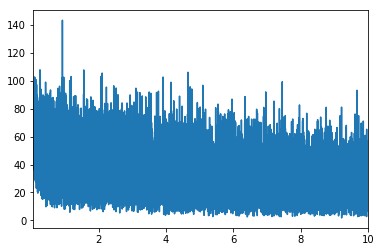

In [57]:
history['train_loss'].iloc[100:].plot();

In [58]:
torch.save(model.state_dict(), './model.pth')

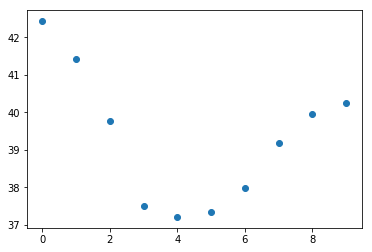

In [59]:
series = history.dropna()['dev_loss']
plt.scatter(series.index, series);

# Visualize predictions

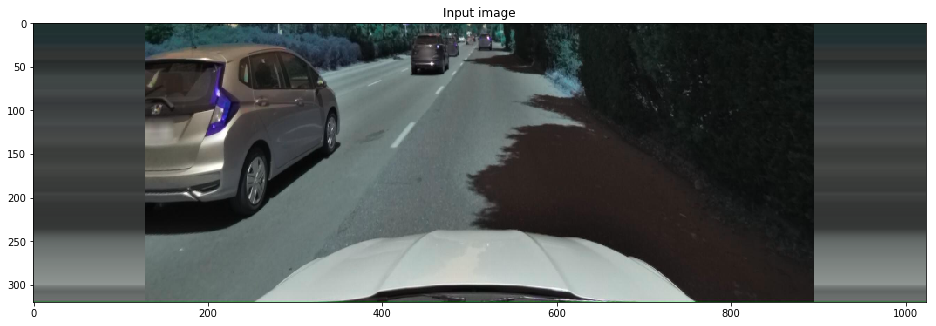

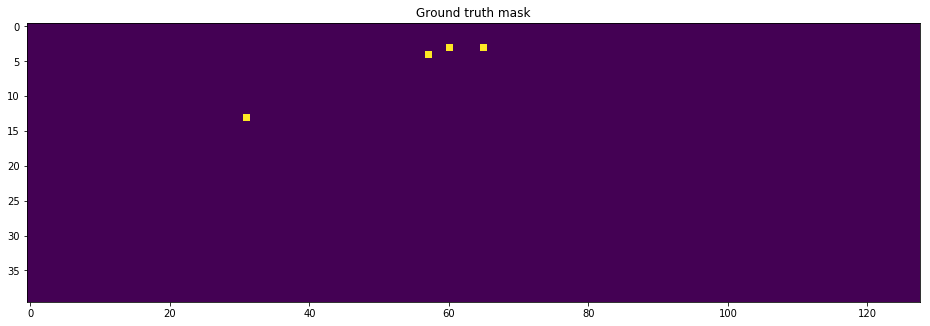

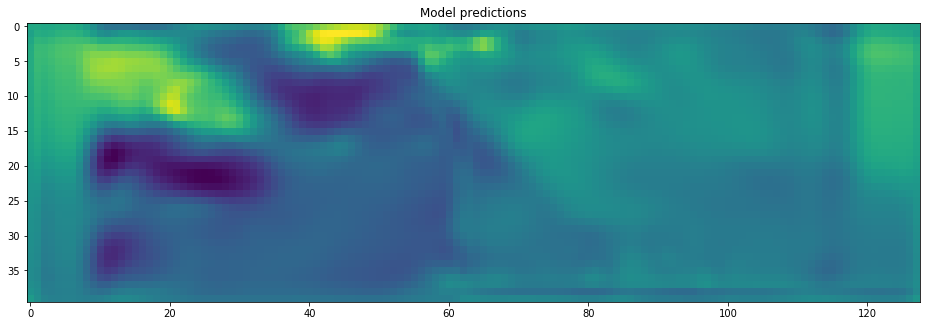

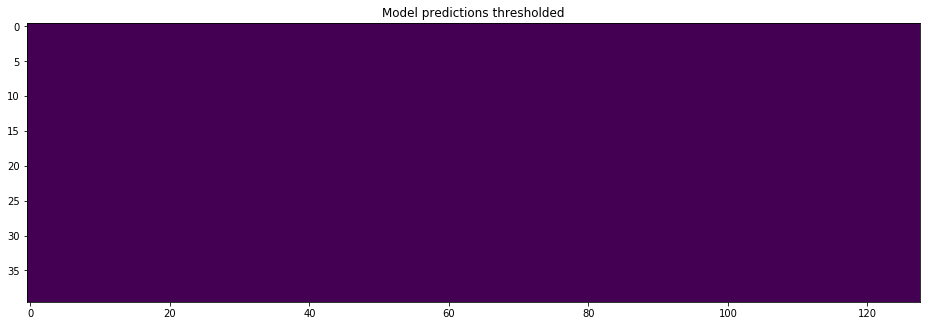

In [60]:
img, mask, regr = dev_dataset[120]

plt.figure(figsize=(16,16))
plt.title('Input image')
plt.imshow(np.rollaxis(img, 0, 3))
plt.show()

plt.figure(figsize=(16,16))
plt.title('Ground truth mask')
plt.imshow(mask)
plt.show()

output = model(torch.tensor(img[None]).to(device))
logits = output[0,0].data.cpu().numpy()

plt.figure(figsize=(16,16))
plt.title('Model predictions')
plt.imshow(logits)
plt.show()

plt.figure(figsize=(16,16))
plt.title('Model predictions thresholded')
plt.imshow(logits > 0)
plt.show()

In [61]:
torch.cuda.empty_cache()
gc.collect()

for idx in range(8):
    img, mask, regr = dev_dataset[idx]
    
    output = model(torch.tensor(img[None]).to(device)).data.cpu().numpy()
    coords_pred = extract_coords(output[0])
    coords_true = extract_coords(np.concatenate([mask[None], regr], 0))
    
    img = imread(train_images_dir.format(df_dev['ImageId'].iloc[idx]))
    
    fig, axes = plt.subplots(1, 2, figsize=(30,30))
    axes[0].set_title('Ground truth')
    axes[0].imshow(visualize(img, coords_true))
    axes[1].set_title('Prediction')
    axes[1].imshow(visualize(img, coords_pred))
    plt.show()

TypeError: extract_coords() missing 1 required positional argument: 'camera_intrinsic'

# Make submission

In [ ]:
predictions = []

test_loader = DataLoader(dataset=test_dataset, batch_size=4, shuffle=False, num_workers=4)

model.eval()

for img, _, _ in tqdm(test_loader):
    with torch.no_grad():
        output = model(img.to(device))
    output = output.data.cpu().numpy()
    for out in output:
        coords = extract_coords(out)
        s = coords2str(coords)
        predictions.append(s)

In [ ]:
test = pd.read_csv(PATH + 'sample_submission.csv')
test['PredictionString'] = predictions
test.to_csv('predictions.csv', index=False)
test.head()